In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk

(examples:cbed_quickstart)=
# CBED quickstart

This notebook demonstrates a basic CBED simulation of silicon in the $(111)$ zone axis.

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [2]:
abtem.config.set(
    {
        "device": "cpu",
        "fft": "fftw",
        "diagnostics.task_progress": True,
        "diagnostics.progress_bar": "tqdm",
    }
)

## Atomic model
We create the atomic model. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

We create an atomic model of silicon using the `bulk` function from ASE.

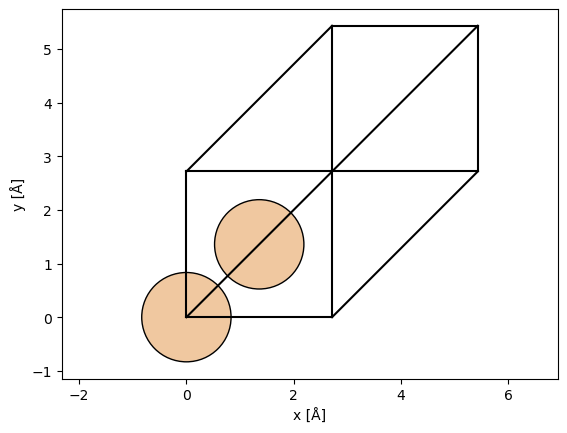

In [3]:
silicon = bulk("Si", crystalstructure="diamond")

abtem.show_atoms(silicon, plane="xy");

We can choose the $(111)$ zone axis to be a propagation direction using the `surface` function. 

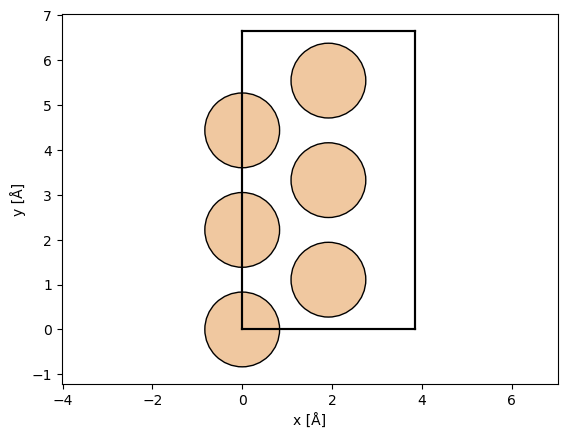

In [4]:
silicon_111 = ase.build.surface(
    silicon, (1, 1, 1), layers=3, periodic=True
)  # create surface structure in the (111) direction

silicon_111_orthogonal = abtem.orthogonalize_cell(silicon_111)  # make cell orthogonal

abtem.show_atoms(silicon_111_orthogonal);

Finally we repeat the structure in $x$ and $y$, this will improve the reciprocal space resolution. We also repeat the structure in $z$, thus simulating a thicker sample.

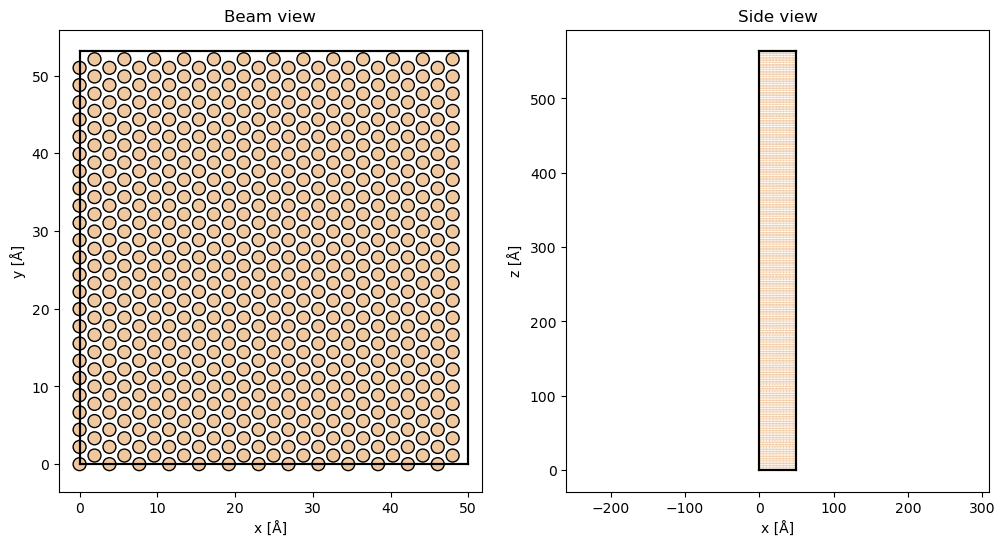

In [5]:
atoms = silicon_111_orthogonal * (13, 8, 60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
abtem.show_atoms(atoms, ax=ax1, title="Beam view")
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", linewidth=0.0);

## Potential

We create an ensemble of potentials using the frozen phonon. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [6]:
frozen_phonons = abtem.FrozenPhonons(atoms, 8, {"Si": 0.078})

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [7]:
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.1,
    projection="infinite",
    slice_thickness=2,
    exit_planes=60,
)

## Wave function

We create a probe wave function at an energy of 100 keV with a convergence semiangle of $9.4 \ \mathrm{mrad}$. See our [walkthrough on wave functions](walkthrough:wave_functions). 

Partial temporal coherence is neglected here, see our [tutorial on partial coherence](tutorials:partial_coherence) if you want to include this in your simulation.

In [8]:
wave = abtem.Probe(energy=100e3, semiangle_cutoff=9.4)
wave.grid.match(potential)

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

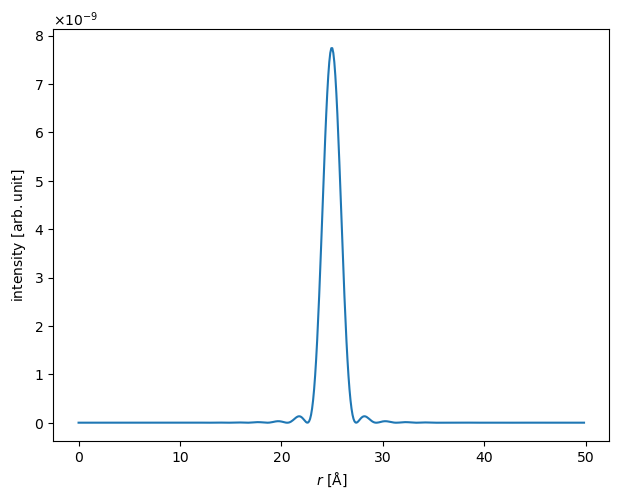

In [9]:
wave.profiles().show();

## Multislice

We run the multislice algorithm and calculate the diffraction patterns, see our [walkthrough on multislice](walkthrough:multislice).

In [10]:
measurement = wave.multislice(potential).diffraction_patterns(max_angle=30)

We take the mean across the frozen phonons axis, and compute the result.

In [11]:
measurement = measurement.mean(0)

measurement.compute()

tasks:   0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

## Visualize results

We show the thickness series as an exploded plot.

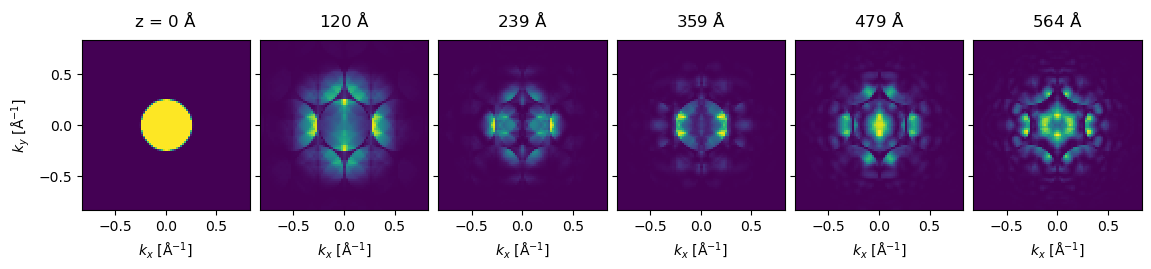

In [12]:
visualization = measurement.show(
    explode=True,
    figsize=(12, 5),
)

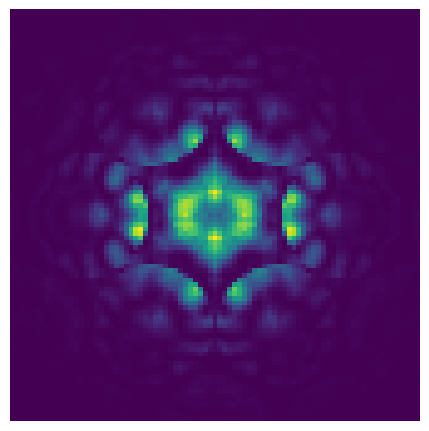

In [13]:
# this cell produces a thumbnail for the online documentation

visualization = measurement[-1].show()
visualization.axis_off()
plt.savefig("../thumbnails/cbed_quickstart.png", bbox_inches="tight", pad_inches=0)